In [4]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import scipy
import time

import keras
from keras.optimizers import Adadelta
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.initializers import glorot_uniform
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML, display, clear_output, SVG
import ipywidgets as widgets
#%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.makedirs('models')

# Data Processing

In [ ]:
classes = os.listdir('C:/afranklin/UB/CSE676/HW1/by_class')

data_pairs = []
for class_int, class_dir in enumerate(classes):
    image_path = 'C:/afranklin/UB/CSE676/HW1/by_class/{}/train_{}/'.format(class_dir, class_dir)
    image_files = os.listdir(image_path)
    for d in [image_path + img for img in image_files]:
        data_pairs.append((d, class_int))
        
x_data = np.array(data_pairs)[::,0]
y_data = keras.utils.to_categorical(np.array(data_pairs)[::,1], len(classes))

In [3]:
full_idx = np.arange(0, len(x_data))
train_idx = np.random.choice(full_idx, 
                             int(len(x_data)*0.8), 
                             replace=False)
test_idx = np.setdiff1d(full_idx, train_idx)

x_train = x_data[train_idx]
y_train = y_data[train_idx]
x_test = x_data[test_idx]
y_test = y_data[test_idx]

731668
(585334, 62)
(585334,)


40


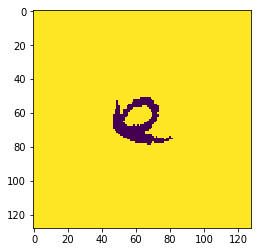

In [4]:
try:
    im = imageio.imread(data_pairs[591000][0], pilmode='L')/255
except TypeError as e:
    im = scipy.misc.imread(data_pairs[591000][0], mode='L')/255
print(data_pairs[590000][1])
plt.imshow(im)

In [5]:
def batch_generator(x, y, batch_size=32):
    while True:
        idx = np.random.randint(0, len(x), batch_size)
        im_files = x[idx]
        ims = []
        labels = y[idx]
        
        for i in im_files:
            try:
                image = imageio.imread(i, pilmode='L')/255
            except TypeError as e:
                image = scipy.misc.imread(i, mode='L')/255
            image = np.expand_dims(image, axis=0)
            ims.append(image)

        yield np.array(ims), labels

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
50


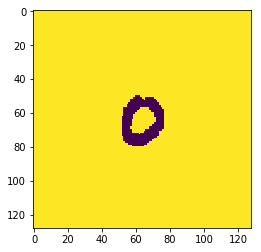

In [6]:
# quick test
for gen, label in batch_generator(x_train, y_train):
    for im, l in zip(gen, label):
        print(l)
        print(np.argmax(l))
        plt.imshow(im.reshape(128,128))
        plt.show()
        break
    break

# Model

conv1.shape (?, 64, 64, 64)
conv2.shape (?, 64, 64, 64)
x.shape (?, 64, 64, 64)
---------block 1 end-----------
conv1.shape (?, 128, 32, 32)
conv2.shape (?, 128, 32, 32)
x.shape (?, 128, 32, 32)
---------block 2 end-----------
conv1.shape (?, 256, 16, 16)
conv2.shape (?, 256, 16, 16)
x.shape (?, 256, 16, 16)
---------block 3 end-----------
conv1.shape (?, 512, 8, 8)
conv2.shape (?, 512, 8, 8)
x.shape (?, 512, 8, 8)
---------block 4 end-----------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1, 128, 128)  0                                            
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 1, 128, 128)  512         input_9[0][0]                    
______________________________________________________

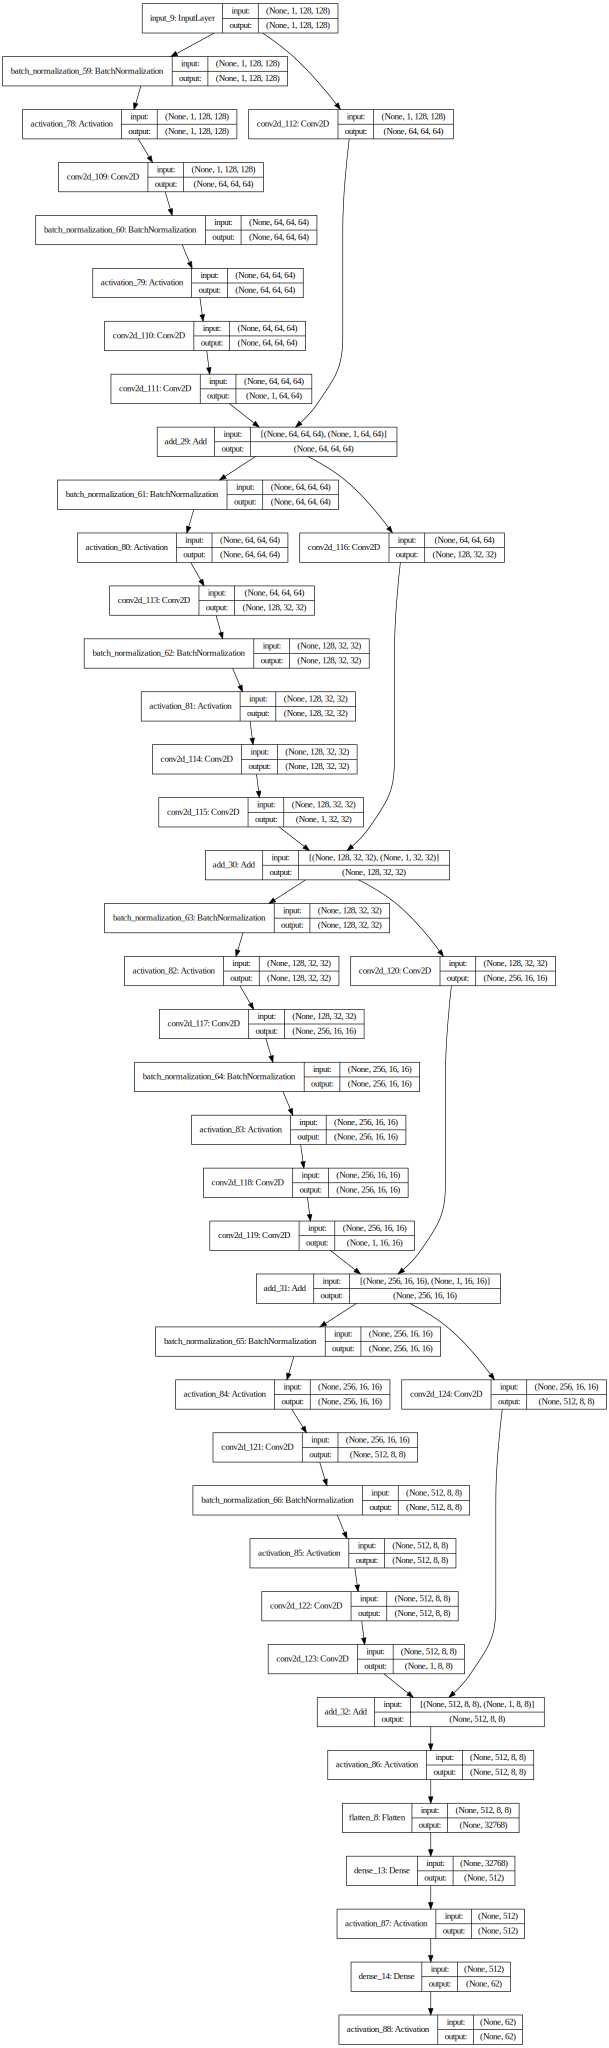

In [17]:
img_rows, img_cols = 128, 128
input_shape = (1, img_rows, img_cols)

input1 = Input(shape=(1, 128, 128))

       
# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    print('conv2.shape', conv2.shape)
    residual = Conv2D(1, (1, 1), strides=(1, 1), data_format='channels_first')(conv2)
    
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    print('x.shape', x.shape)
    out = Add()([x, residual])
    
    return out

# Combining resuidal blocks into a network
res1 = res_block(input1, 64)
res2 = res_block(res1, 128)
res3 = res_block(res2, 256)
res4 = res_block(res3, 512)

# Classifier block
act1 = Activation('relu')(res4)
flatten1 = Flatten()(act1)
dense1 = Dense(512)(flatten1)
act2 = Activation('relu')(dense1)
dense2 = Dense(62)(act2)
output1 = Activation('softmax')(dense2)

model = Model(inputs=input1, outputs=output1)

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(lr=0.1),
              metrics=['categorical_accuracy'])

model.summary()

plot_model(model, to_file='model.png')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

# Training

In [ ]:
callback_list = []
train_name = str(int(time.time()))
initial_epoch = 0
if not os.path.exists('models1/' + train_name):
    os.makedirs('models1/' + train_name)
model_path="models1/" + train_name +"/model_{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"

callback_list.append(EarlyStopping(monitor='val_loss', patience=100))
callback_list.append(TensorBoard(log_dir='./logs/' + train_name))
callback_list.append(ModelCheckpoint(model_path, period=10))

train_gen = batch_generator(x_train, y_train, batch_size=32)
val_gen = batch_generator(x_test[:int(0.5 * x_test.shape[0])], y_test[:int(0.5 * y_test.shape[0]),:], batch_size=32)

hist = model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=8,
                    validation_steps=8,
                    epochs=1000,
                    initial_epoch=initial_epoch,
                    verbose=1,
                    callbacks=callback_list)

Epoch 1/1000
8/8 [==============================] - 243s 30s/step - loss: 4.2637 - categorical_accuracy: 0.0117 - val_loss: 4.1255 - val_categorical_accuracy: 0.1211
Epoch 2/1000
8/8 [==============================] - 231s 29s/step - loss: 4.1255 - categorical_accuracy: 0.0703 - val_loss: 4.1235 - val_categorical_accuracy: 0.0938
Epoch 3/1000
8/8 [==============================] - 246s 31s/step - loss: 4.1245 - categorical_accuracy: 0.0273 - val_loss: 4.1220 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
8/8 [==============================] - 252s 32s/step - loss: 4.1237 - categorical_accuracy: 0.0703 - val_loss: 4.1204 - val_categorical_accuracy: 0.0977
Epoch 5/1000
8/8 [==============================] - 253s 32s/step - loss: 4.1223 - categorical_accuracy: 0.0273 - val_loss: 4.1183 - val_categorical_accuracy: 0.1133
Epoch 6/1000
8/8 [==============================] - 247s 31s/step - loss: 4.1222 - categorical_accuracy: 0.0273 - val_loss: 4.1170 - val_categorical_accuracy: 0.0938


# Evaluation

In [ ]:
model_old = model # just in case
print("Loading saved model...")
model = load_model('models/model.hdf5')

In [ ]:
test_gen = batch_generator(x_test[int(0.5 * x_test.shape[0]):], y_test[int(0.5 * y_test.shape[0]):,:], batch_size=32)

score = model.evaluate_generator(test_gen, steps=10)
print('Test loss:', score[0])
print('Test categorical accuracy:', score[1])

In [ ]:
for x, y in test_gen:
    pred = model.predict(x)
    for xp, l in zip(pred, y):
        print("Predicition:", np.argmax(xp))
        print("Actual     :", np.argmax(l))
        print("----------------------")
    break

# Confusion Matrix

In [ ]:
all_gen = batch_generator(x_test[int(0.5 * x_test.shape[0]):], y_test[int(0.5 * y_test.shape[0]):,:], batch_size=100)
y_true = np.array([])
y_pred = np.array([])

for x, y in all_gen:
    if not y_true.size:
        y_true = y_true.reshape((0, y.shape[1]))
        y_pred = y_true.reshape((0, y.shape[1]))

    y_true = np.concatenate((y_true, y))
    
    _y = model.predict(x)
    y_pred = np.concatenate((y_pred, _y))
    
    if len(y_true) == 1000:
        break

In [ ]:
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
fig = plt.figure(figsize=(16,16))
ax = plt.gca();
ax.set_xticks(np.arange(-.5, len(classes), 1))
ax.set_yticks(np.arange(-.5, len(classes), 1))
ax.set_xticklabels(np.arange(0, len(classes), 1))
ax.set_yticklabels(np.arange(0, len(classes), 1))
ax.imshow(cm)#, cmap="Pastel1")
ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)

# Tensorboard Results

In [ ]:
# saved "hist" results
df = pd.DataFrame(hist.history)
df.plot(figsize=(10,8))

In [ ]:
# saved Tensorboard results
print("Opening saved results...")
df_loss = pd.read_csv('results/loss.csv')
df_val_loss = pd.read_csv('results/val_loss.csv')

plt.figure(figsize=(10,8))
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Loss'),
    mpatches.Patch(color='C1', label='Validation Loss')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)
plt.show()

df_loss = pd.read_csv('results/categorical_accuracy.csv')
df_val_loss = pd.read_csv('results/val_categorical_accuracy.csv')

plt.figure(figsize=(10,8))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Accuracy'),
    mpatches.Patch(color='C1', label='Validation Accuracy')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)
plt.show()